# Step1 - Scrapping

In [1]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scrapy # we will use the scrapy package
import requests
from scrapy.selector import Selector

# Set seaborn display
sns.set()

### Training: scrapping the Polytechnique website

Using selectors, we created a spider which get all the information from polytechnique News page.

#### Running spider 

(Running the spider might take over one minute if you remove the __"-a nb_article_max=100"__ to get all the articles)

In [2]:
# Parameters for spider execution
file_path = '../scrapped_data/'
file_name = 'actuX_basic_nbk_data.jl'
spider_name = 'actuX_basic'
path = file_path + file_name

# Check if file already exists
if file_name in os.listdir(file_path):
    _ = os.remove(path)

# Execution of spider
cmd1 = 'cd ../TA_scrapy/'
cmd2 = 'scrapy crawl {} -o {} -a nb_article_max=100'.format(spider_name, path)
cmd = cmd1 + ' && ' + cmd2
_ = os.system(cmd)

if _==0:
    print("Scrapping finished.")
else:
    print('Look at the bash to understand error.')

Scrapping finished.


#### Reading scrapped data

In [3]:
# Function rto read jl file
def read_jl_file(file_name):
    values = []
    with open(file_name, 'rb') as f:
        line = '---'
        while len(line)>1:
            line = f.readline()
            values.append(line)
    values = values[:-1]
    values = [json.loads(i) for i in values]
    df = pd.DataFrame(values)
    return df

# Reading file
df = read_jl_file(path)

In [4]:
# Having a brief look at data
print(df.shape)

df.head()

(100, 6)


,content,date_article,lien_article,related_subject,related_subject_links,titre_article
0,La 28e édition du challenge international d'es...,6 Février 2020,/fr/content/28e-edition-du-challenge-descrime-...,[Campus],[/fr/type/campus],28e édition du challenge d'escrime X-Systra
1,L’École polytechnique est le 1er établissement...,30 Janvier 2020,/fr/content/lx-la-plus-internationale-des-univ...,[Classement],[/fr/classement],"L’X, la plus internationale des universités fr..."
2,Les priorités de l’X pour 2020 s’inscrivent da...,28 Janvier 2020,/fr/content/lecole-polytechnique-fixe-ses-prio...,"[Institutionnel, Campus]","[/fr/type/institutionnel, /fr/type/campus]",L’École polytechnique fixe ses priorités pour ...
3,"Le 14 février 2020, l’X célèbre les 35 ans de ...",28 Janvier 2020,/fr/content/lamplification-laser-35-ans-apres-...,"[Recherche, Conference]","[/fr/les-actualites-de-la-recherche, /fr/confe...","L’amplification laser : 35 ans après, des pote..."
4,Deux équipes de trois élèves de l’X sont arriv...,27 Janvier 2020,/fr/content/lx-remporte-pour-la-premiere-fois-...,"[Campus, Prix]","[/fr/type/campus, /fr/prix-et-distinctions]",L’X remporte pour la première fois le concours...


#### Brief analysis of scrapped data

__Seeing the most frequent mentions__

In [5]:
related_subjects = []
for subjects in df['related_subject'].tolist():
    related_subjects += subjects     
pd.Series(related_subjects).value_counts().head()

Recherche          54
Campus             18
Formation          17
Prix               12
Entrepreneuriat    11
dtype: int64

__Counting the number of publications through times__

In [6]:
def translate_month(x):
    translate_dict = {
        'Janvier':'january',
        'Février':'february',
        'Mars':'march',
        'Avril':'april',
        'Mai':'may',
        'Juin':'june',
        'Juillet':'july',
        'Aout':'august',
        'Septembre':'september',
        'Octobre':'october',
        'Novembre':'november',
        'Décembre':'december'}
    for french, english in translate_dict.items():
        x = x.replace(french, english)
    return x

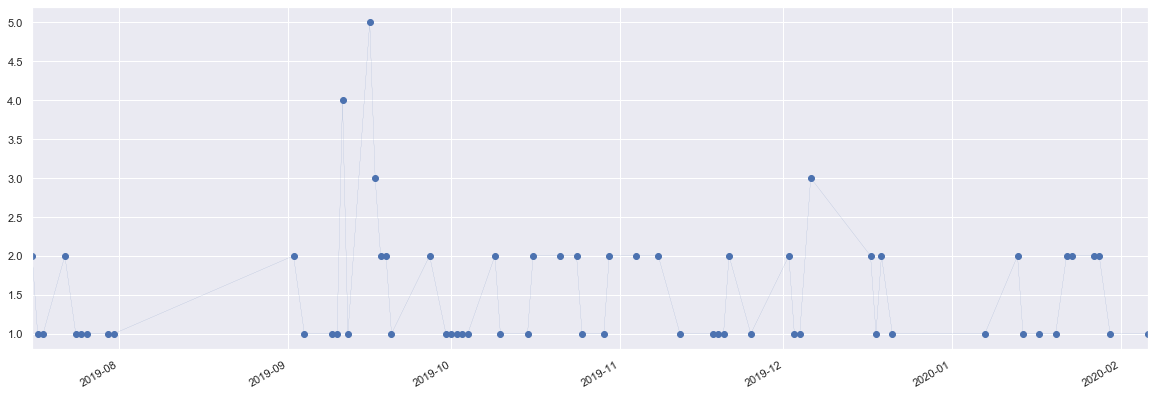

In [7]:
# Transforming French date into English date so that pandas understands it as a date
df['date'] = df['date_article'].apply(translate_month)

# Preparing for plotting
tmp = pd.to_datetime(df['date'], errors='coerce').value_counts()

# Realizing plotting
_ = plt.figure(figsize=(20,7))
_ = tmp.plot(marker='o', linewidth=0.1)
_ = plt.show()

### Project: scrapping TripAdvisor

#### Discovering TripAdvisor

Here is how we will proceed before building our spider:
- Open a review page and check how to parse it
- Open a restaurant page and check how to get reviews urls
- Open a restaurant page and check how to get to next page of reviews
- Open a city page and check how to get restaurant urls
- Open a city page and check how to get the net page of restaurants
- Try to put it altogether

In [1]:
# To begin with, 3 urls types
example_url_city = 'https://www.tripadvisor.co.uk/Restaurants-g187147-Paris_Ile_de_France.html'
example_url_restaurant = 'https://www.tripadvisor.co.uk/Restaurant_Review-g187147-d9806534-Reviews-ASPIC-Paris_Ile_de_France.html'
example_url_review = 'https://www.tripadvisor.co.uk/ShowUserReviews-g187147-d9806534-r731227577-ASPIC-Paris_Ile_de_France.html'

#### Preparing selectors in spider perspective

**Parsing restaurant list**

In [8]:
# This code gives the urls of alle the restaurants (the one given by capgemini doesn't work. They don't have the right adresses)
url = 'https://www.tripadvisor.co.uk/Restaurants-g191259-Greater_London_England.html'
html = requests.get(url).content
sel = Selector(text=html)
rep = sel.css('div.wQjYiB7z > span > a ::attr(href)').extract()
print(rep)
restaurants_urls = rep

['/Restaurant_Review-g1646066-d13110428-Reviews-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/Restaurant_Review-g191260-d5999531-Reviews-Madhu_s_Heathrow-Hayes_Greater_London_England.html', '/Restaurant_Review-g528819-d10490489-Reviews-Umi-Twickenham_Greater_London_England.html', '/Restaurant_Review-g2549055-d6522688-Reviews-Rendez_Vous_Caffe-Beckenham_Greater_London_England.html', '/Restaurant_Review-g1646049-d12460152-Reviews-Ottimmo_Bao_Bao-Uxbridge_Greater_London_England.html', '/Restaurant_Review-g528818-d2306043-Reviews-La_Dolce_Vita-Teddington_Richmond_upon_Thames_Greater_London_England.html', '/Restaurant_Review-g1646063-d13428223-Reviews-ITJL-Edgware_Greater_London_England.html', '/Restaurant_Review-g186338-d12569115-Reviews-Wild_Thyme-London_England.html', '/Restaurant_Review-g1934185-d15563947-Reviews-The_Orpington-Orpington_Bromley_Greater_London_England.html', '/Restaurant_Review-g528820-d14766084-Reviews-Taste_Of_Peshawar-Wembley_Greater_London_England.ht

In [9]:
# This function will clean the given list of restaurants: 

def cleaning_list_of_restaurants(L):
    T=[]
    Answer = []
    test = True
    for i in range(1,31):
        T.append(str(i))
    T.append('. ')
    for j in range(len(L)):
        for i in range(len(T)):
            if L[j] == T[i]:
                test = False
        if test == True:
            Answer.append(L[j])
        test = True
    return(Answer)

In [10]:
# We extract the list of restaurants
# Note that we were able to extract 4 Locos Argentine Steakhouse even if it starts with a number
url = 'https://www.tripadvisor.co.uk/Restaurants-g191259-Greater_London_England.html'
html = requests.get(url).content
sel = Selector(text=html)
rep = sel.css('div.wQjYiB7z > span > a ::text').extract()
list_of_restaurants = cleaning_list_of_restaurants(rep)
list_of_restaurants 

['Sipson Tandoori Indian Restaurant',
 'Karahi Junction',
 'Umi',
 'Rendez Vous Caffe',
 'Ottimmo Bao Bao',
 'La Dolce Vita',
 'ITJL',
 'Wild Thyme',
 'the Orpington',
 'Taste Of Peshawar',
 'The Lounge Cafe',
 'Sidra',
 'MOMO & ROTI',
 'The French Table',
 'Mezzet Lebanese Restaurant',
 'Sweet Rose Cakery',
 'La Plata Steakhouse',
 'Oliveira Organic Vegetarian Kitchen',
 'Revolution',
 '4 Locos Argentine Steakhouse',
 "L'oro di Napoli",
 'Masa Restaurant',
 'Ponte Nuovo',
 'Mezzet Dar',
 'Doosra',
 'Indian Panorama Restaurant',
 'Tony Parkin at The Tudor Room',
 'The Clink Restaurant',
 'Namaste Gurkha',
 "Melucci's",
 'Awesome Thai',
 'Lentil']

**Parsing restaurant page**

In [11]:
# This code gives the urls of alle the reviews of a given restaurant (I start with Umi for the example)
url = 'https://www.tripadvisor.co.uk/Restaurant_Review-g528819-d10490489-Reviews-Umi-Twickenham_Greater_London_England.html'
html = requests.get(url).content
sel = Selector(text=html)
rep = sel.css('div.quote > a ::attr(href)').extract()
print(rep)
reviews_urls = rep

['/ShowUserReviews-g528819-d10490489-r740096520-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r739986559-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r736769770-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r735526111-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r735308864-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r734126059-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r732038606-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r731886968-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r729671967-Umi-Twickenham_Greater_London_England.html', '/ShowUserReviews-g528819-d10490489-r728429794-Umi-Twickenham_Greater_London_England.html']


In [12]:
#Doing the same for each url
for url in restaurants_urls:
    url = 'https://www.tripadvisor.co.uk'+url
    html = requests.get(url).content
    sel = Selector(text=html)
    rep = sel.css('div.quote > a ::attr(href)').extract()
    print(rep)    

['/ShowUserReviews-g1646066-d13110428-r743379985-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r742409066-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r736099989-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r733091165-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r728396617-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r703904333-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r700996000-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r693169979-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-g1646066-d13110428-r687767334-Kulcha_Express-Southall_Ealing_Greater_London_England.html', '/ShowUserReviews-

['/ShowUserReviews-g528820-d14766084-r742593802-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r741628177-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r740869690-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r740866237-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r740313815-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r739171044-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r738627351-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r737684456-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r736864342-Taste_Of_Peshawar-Wembley_Greater_London_England.html', '/ShowUserReviews-g528820-d14766084-r736119057-Taste_Of_Peshawar-Wembley

['/ShowUserReviews-g186338-d13915112-r743016310-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r741730523-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r738741407-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r738688971-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r736356900-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r733645461-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r732792368-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r731051548-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r730284856-Oliveira_Organic_Vegetarian_Kitchen-London_England.html', '/ShowUserReviews-g186338-d13915112-r729760152-Oliveir

['/ShowUserReviews-g504169-d19092676-r742163120-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r741967340-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r741608798-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r741298481-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r741268358-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r740796989-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r739249911-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r739111000-Indian_Panorama_Restaurant-East_Molesey_Molesey_Surrey_England.html', '/ShowUserReviews-g504169-d19092676-r738694594-Indian_Panorama_

In [13]:
# This code gives the title of each review 

rep = sel.css('div.quote > a > span::text').extract_first()
print(rep)

We decided to try as we read


In [14]:
# This code gives the dates of the reviews 
rep = sel.css('div.prw_rup.prw_reviews_stay_date_hsx ::text').extract()
print(rep)

['Date of visit:', ' February 2020', 'Date of visit:', ' January 2020', 'Date of visit:', ' January 2020', 'Date of visit:', ' January 2020', 'Date of visit:', ' December 2019', 'Date of visit:', ' November 2019', 'Date of visit:', ' December 2019', 'Date of visit:', ' December 2019', 'Date of visit:', ' December 2019', 'Date of visit:', ' November 2019']


In [15]:
# Let's get a better visualization : 

Answer = []
i = 1
for x in range(len(rep)):
    if x%2 == 1:
        Answer.append('The date of the review number '+str(i)+' is:' + rep[x])
        i +=1
print(Answer)

['The date of the review number 1 is: February 2020', 'The date of the review number 2 is: January 2020', 'The date of the review number 3 is: January 2020', 'The date of the review number 4 is: January 2020', 'The date of the review number 5 is: December 2019', 'The date of the review number 6 is: November 2019', 'The date of the review number 7 is: December 2019', 'The date of the review number 8 is: December 2019', 'The date of the review number 9 is: December 2019', 'The date of the review number 10 is: November 2019']


In [16]:
#This code extract all the text reviews
rep = sel.css('p.partial_entry ::text').extract()
print(rep)

['We decided to try as we read the reviews. Well it’s a total 5 for us. Staff so friendly, food amazing. Not rushed at all.\nWhat a find. The Chablis is fantastic. Will definitely be back soon.', 'Great tasting food, and the staff are outstanding and always willing to go the extra mile to work out what you want, and when it comes it always is.', 'Food was great, really enjoyed the chicken masala with rice. Had a fab night and the chef was really nice', "We had a wonderful meal at Lentil last week and were helped from start to finish by the lovely gentleman who served us. We were a family of four with a variety of dietary preferences and restrictions! But this didn't put him off - he...", 'More', 'Very attentive service and first rate food - you can tell this is a family run restaurant.\n\nThe mono’s are highly recommended along with the keema peas and makhani dhal.\n\nI can’t recommended the food highly enough - We will definitely go again!!', 'Looking at recent reviews which claim tha

In [17]:
#This code gives the number of pepople giving a certain score :
rep = sel.css('span.row_num.is-shown-at-tablet ::text').extract()
Answer = []
for i in range(len(rep)):
    Answer.append(rep[i]+' people gave '+str(5-i)+' stars to this restaurant')
Answer

['254 people gave 5 stars to this restaurant',
 '27 people gave 4 stars to this restaurant',
 '7 people gave 3 stars to this restaurant',
 '4 people gave 2 stars to this restaurant',
 '2 people gave 1 stars to this restaurant']

In [18]:
# This code gives the average score of the restaurant : I think we can get it directly from the website, but I was not able to do it:
Total = 0
Total_score = 0
Score = 0
for i in range(len(rep)):
    Total += int(rep[i])
    Total_score = Total_score + int(rep[i])*(5-i)
Score = Total_score/Total
Score

4.792517006802721

**Parsing review**

In [19]:
# This code extracts the main paragraphe of the review,  I'll go with the first one of UMI.
url = 'https://www.tripadvisor.co.uk/ShowUserReviews-g528819-d10490489-r740096520-Umi-Twickenham_Greater_London_England.html'
html = requests.get(url).content
sel = Selector(text=html)
rep = sel.css('p.partial_entry ::text').extract_first()
print(rep)

An authentic Japanese restaurant in an intimate setting. Sushi and sashimi done to perfection, well explained by the immensely friendly staff. Complimentary miso is exceptional - you’re well looked after! A lovely katsu also. We will be back! 


In [20]:
# This code gives the pseudonyme of the person who gave the review
rep = sel.css('DIV.prw_rup.prw_reviews_member_info_hsx .username .scrname ::text').extract_first()
print(rep)

858benl


In [21]:
# This code gives the pseudonyme of each person who gave a review
rep = sel.css('DIV.prw_rup.prw_reviews_member_info_hsx .username .scrname ::text').extract()
print(rep)

['858benl', 'BarnabyHilbourne', 'ThereseW25', 'IncognitoSommelier', 'JOHN T']


**Navigating between pages**

In [22]:
# To do the parsing for each page, a for loop using the urls list will be enought
# we juste need to use this: 
tripadvisor = 'https://www.tripadvisor.co.uk'
# then the link will be 'tripadvisor + link found in the list'

#### Scrapping using the spider

In [23]:
# Parameters for spider execution
import os
file_path = '../scrapped_data/'
file_name = 'ReviewRestoSpider.jl'
spider_name = 'RestoReviewSpider'
path = file_path + file_name

# Check if file already exists
if file_name in os.listdir(file_path):
    _ = os.remove(path)

# Execution of spider
cmd1 = 'cd ../TA_scrapy/'
cmd2 = 'scrapy crawl {} -o {} '.format(spider_name, path)
cmd = cmd1 + ' && ' + cmd2
_ = os.system(cmd)

if _==0:
    print("Scrapping finished.")
else:
    print('Look at the bash to understand error.')

Scrapping finished.


In [24]:
# Function rto read jl file
def read_jl_file(file_name):
    values = []
    with open(file_name, 'rb') as f:
        line = '---'
        while len(line)>1:
            line = f.readline()
            values.append(line)
    values = values[:-1]
    values = [json.loads(i) for i in values]
    df = pd.DataFrame(values)
    return df

# Reading file
df = read_jl_file(path)

In [25]:
df.shape

(3660, 5)

In [26]:
df

,Rating,Restaurant_name,name,partial content,title
0,[5 of 5 bubbles],[ Namaste Gurkha ],Naheed R,Amazing friendly staff. Very good prices. Food...,Great food even better service
1,[5 of 5 bubbles],[ Namaste Gurkha ],leona939,"Great food, friendly staff, decent prices. I h...",Great food
2,[5 of 5 bubbles],[ Melucci's ],kazowen,"The most amazing breakfast, ingredients fresh ...",Breakfast Bliss
3,[4 of 5 bubbles],[ Awesome Thai ],richardcC3581NV,So why not five stars? Everything was was very...,"Friendly staff, good food, good portions"
4,[5 of 5 bubbles],[ Indian Panorama Restaurant ],LuxeLoverLdn,Took my mum for a midweek lunch. 10/10 service...,Go here!
5,[5 of 5 bubbles],[ Awesome Thai ],faiths687,I’ve visited here twice this restaurant twice ...,Beautiful food and lovely service
6,[5 of 5 bubbles],[ Indian Panorama Restaurant ],Lovesbitez,"Really lovely food, fresh and tasty. Perfect ....",Ann
7,[5 of 5 bubbles],[ Doosra ],phcsmith,It was the ethical ethos of this restaurant th...,Ethical Indian restaurant well worth a visit
8,[5 of 5 bubbles],[ Doosra ],David M,What a surprisingly super culinary experience....,It's rare to find a really good authentic nort...
9,[5 of 5 bubbles],[ Mezzet Dar ],199willk,I love this place! The food is top notch and t...,A brilliant restaurant - delicious food and ex...
